<a href="https://colab.research.google.com/github/heidarimohsen92/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import os
import PIL
import time
import glob
from tensorflow import keras
from IPython import display
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio


# Loading the tf_flowers dataset and preprocessing it

In [4]:
(train_datasets,  test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:100%]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


# Apply augmentation to a dataset

In [5]:
# resize images and rescale the pixel values to [0, 1] range
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [image_size, image_size])
    image = image / 255  # Normalize the images to [0, 1]
    return image, label

def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random Randomly horizontal flip.
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    return image#, label

# Map the augment function to the training dataset

In [6]:
image_size = 64
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

# Create tf.data.Dataset.
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.Dataset.counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

# Map the wrapper function f to the training dataset
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

train_ds

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

# Creating the discriminator and generator

## The Generator

In [7]:
# Create the generator.
numFilters = 64

generator = keras.Sequential(
    [
        keras.layers.InputLayer((latent_dim )),
        # We want to generate 100 coefficients to reshape into a 4x4x512 map.
        layers.Dense(4 * 4 * 512),
        layers.Reshape((4, 4, 512)),
     
        layers.Conv2DTranspose(4*numFilters, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(2*numFilters, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
     
        layers.Conv2DTranspose(numFilters, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
     
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), activation="sigmoid", padding="same"),
    ],
    name="generator",
)

In [8]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      81

## The Discriminator

In [9]:
dropoutProb = 0.5
numFilters = 64

# Create the discriminator.
discriminator = keras.Sequential(
    [
        layers.InputLayer((64, 64, 3)),
        layers.Dropout(dropoutProb),
        layers.Conv2D(numFilters, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
     
        layers.Conv2D(2*numFilters, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
     
        layers.Conv2D(4*numFilters, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
     
        layers.Conv2D(8*numFilters, (5, 5), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
     
        # layers.Conv2D(1, (4, 4), strides=(2, 2), padding="same", activation="sigmoid"),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1, activation="sigmoid")
    ],
    name="discriminator",
)


In [10]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                     

# Define the loss and optimizers

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

# Save checkpoints

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Define the training loop

In [13]:
EPOCHS = 1000
latent_dim = 100
num_examples_to_generate = 16
batch_size = 64
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate and save images

In [16]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train the model

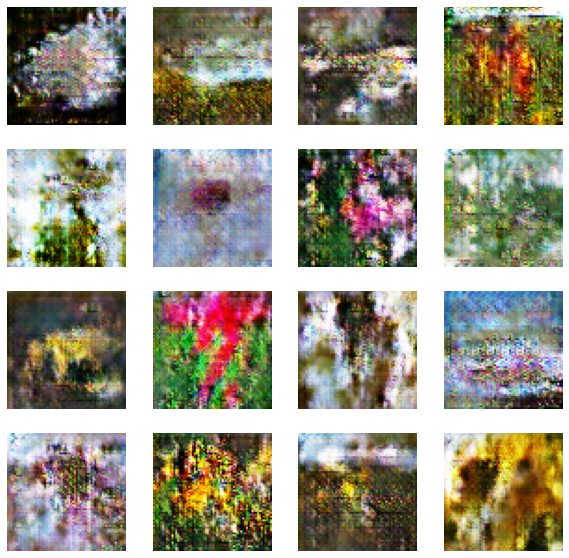

In [17]:
train(train_ds, EPOCHS)

# save weights

In [19]:
!mkdir ./weights/
generator.save_weights('/weights/generator_weights.h5')
# generator.load_weights('/weights/generator_weights.h5')

discriminator.save_weights('/weights/discriminator_weights.h5')
# discriminator.load_weights('/weights/discriminator_weights.h5')

# Create a GIF

In [21]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

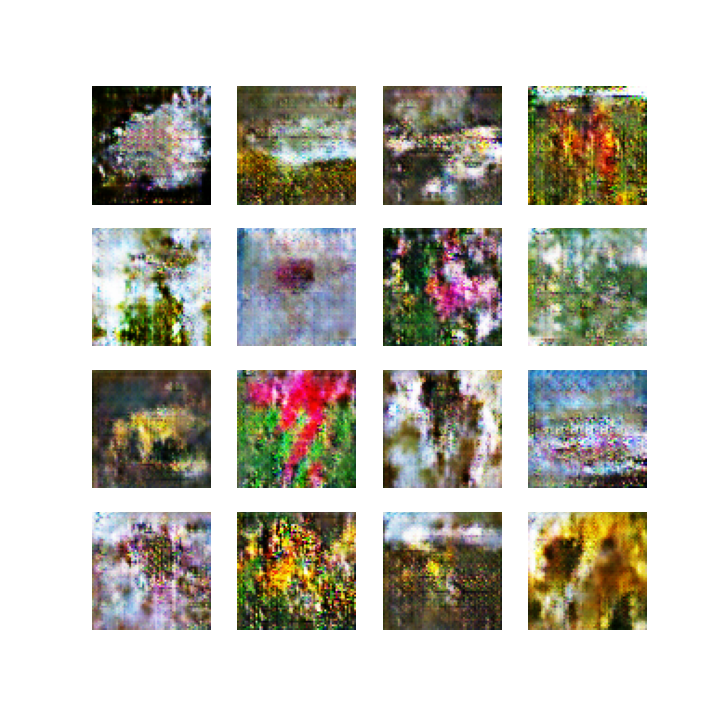

In [22]:
display_image(EPOCHS)

In [56]:
# Use imageio to create an animated gif using the images saved during training.

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  lastname = filenames[-1]
  filenames = filenames[: : 100]
  filenames.append(lastname)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [57]:
filenames

['image_at_epoch_0001.png',
 'image_at_epoch_0101.png',
 'image_at_epoch_0201.png',
 'image_at_epoch_0301.png',
 'image_at_epoch_0401.png',
 'image_at_epoch_0501.png',
 'image_at_epoch_0601.png',
 'image_at_epoch_0701.png',
 'image_at_epoch_0801.png',
 'image_at_epoch_0901.png',
 'image_at_epoch_1000.png']

In [24]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done



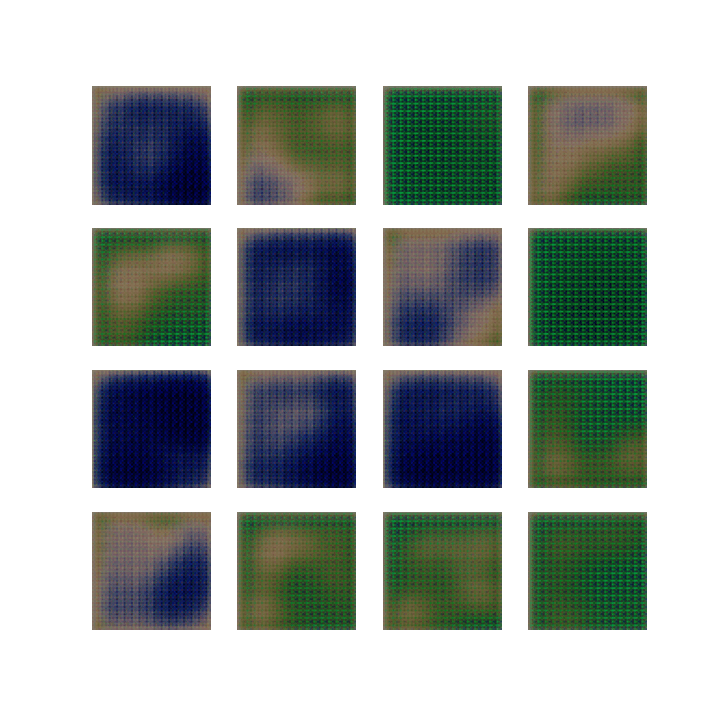

In [58]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)